In [1]:
# imports
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F

from collections import Counter
from matplotlib import pyplot as plt
from pathlib import Path
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import WeightedRandomSampler
from torchvision import datasets, transforms
from tqdm.notebook import tqdm

%matplotlib inline

# Load Data

In [2]:
SEED = 0
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(SEED)

In [3]:
DATA_DIR = "/kaggle/input/ioai-journey-to-springfield/journey-springfield/"
N_CORES = 2

In [4]:
BATCH_SIZE = 256
RESCALE_SIZE = 224
DEVICE = torch.device("cpu")

if torch.cuda.is_available():
    print('CUDA is available! Training on GPU...')
    DEVICE = torch.device("cuda")
else:
    print('CUDA is not available. Training on CPU...')

CUDA is available! Training on GPU...


In [5]:
TRAIN_DIR = Path(DATA_DIR + 'train/simpsons_dataset')
TEST_DIR = Path(DATA_DIR + 'testset/testset')

train_files = sorted(list(TRAIN_DIR.rglob('*.jpg')))
train_labels = [path.parent.name for path in train_files]
test_files = sorted(list(TEST_DIR.rglob('*.jpg')))

## Augmentations

In [6]:
augmentations = transforms.RandomChoice([
    transforms.Compose([
        transforms.Resize(size=300, max_size=301),
        transforms.CenterCrop(size=300),
        transforms.RandomCrop(250)
    ]),
    transforms.RandomRotation(degrees=(-25, 25)),
    transforms.RandomHorizontalFlip(p=1),
])
train_transforms = transforms.Compose([
    augmentations,
    transforms.Resize(size=(RESCALE_SIZE, RESCALE_SIZE)),
    transforms.Lambda(lambda x: np.array(x, dtype="float32") / 255),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) ,
])
train_dataset = datasets.ImageFolder(root=TRAIN_DIR, transform=train_transforms)

In [7]:
class_count = Counter(train_dataset.targets)
class_weights = {i: 1/c for i, c in class_count.items()}
sample_weights = [0] * len(train_dataset)
for i, (data, label) in enumerate(tqdm(train_dataset)):
    class_weight = class_weights[label]
    sample_weights[i] = class_weight

N = max(class_count.values()) * len(class_count)  # fit to max
train_sampler = WeightedRandomSampler(sample_weights, num_samples=N, replacement=True)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, sampler=train_sampler, num_workers=N_CORES)

  0%|          | 0/20933 [00:00<?, ?it/s]

In [8]:
count = Counter()
for data, labels in tqdm(train_loader):
    count += Counter(labels.tolist())
print(sum(count.values()), count)

  0%|          | 0/369 [00:00<?, ?it/s]

94332 Counter({19: 2353, 6: 2322, 4: 2321, 40: 2319, 30: 2314, 26: 2307, 35: 2297, 21: 2296, 1: 2295, 25: 2292, 0: 2285, 15: 2281, 7: 2275, 32: 2274, 23: 2266, 24: 2262, 34: 2259, 10: 2258, 11: 2250, 22: 2249, 36: 2248, 12: 2246, 33: 2245, 28: 2240, 5: 2238, 39: 2234, 14: 2233, 16: 2226, 18: 2216, 41: 2216, 37: 2211, 27: 2209, 29: 2202, 38: 2200, 2: 2199, 3: 2197, 9: 2191, 20: 2186, 13: 2172, 8: 2165, 31: 2143, 17: 2140})


In [9]:
def imshow(inp, title=None, plt_ax=plt, default=False):
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt_ax.imshow(inp)
    if title is not None:
        plt_ax.set_title(title)
    plt_ax.grid(False)

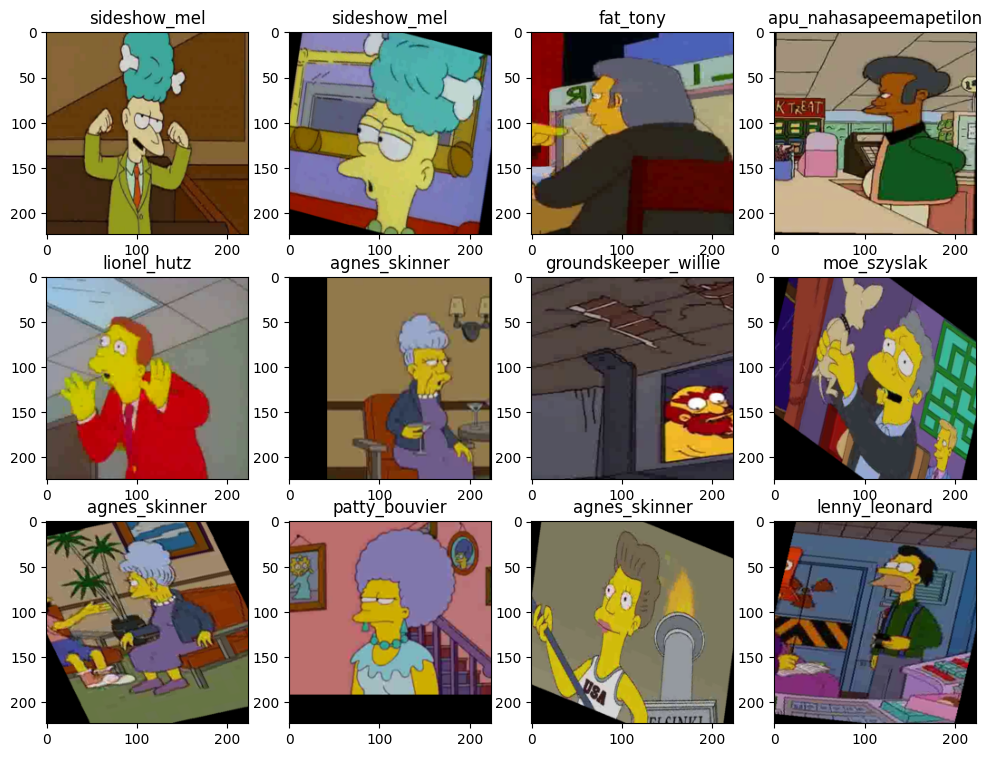

In [10]:
axes = plt.subplots(nrows=3, ncols=4, figsize=(12, 9))[1]
data, labels = next(iter(train_loader))
for ax, d, l in zip(axes.flatten(), data, labels):
    imshow(d.data.cpu(), title=train_dataset.classes[l], plt_ax=ax)

# Train Model

In [11]:
def fit_epoch(model, train_loader, criterion, optimizer, scheduler):
    running_loss = 0.0
    running_corrects = 0
    processed_data = 0
  
    for inputs, labels in train_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        preds = F.softmax(outputs, dim=-1).argmax(-1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_data += inputs.size(0)
              
    scheduler.step()
    train_loss = running_loss / processed_data
    train_acc = running_corrects.cpu().numpy() / processed_data
    return train_loss, train_acc

In [12]:
def train(model, loss, optimizer, scheduler, epochs, batch_size):
    history = []
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} train_acc {t_acc:0.4f}"

    with tqdm(desc="epoch", total=epochs) as pbar_outer:
        for epoch in range(epochs):
            train_loss, train_acc = fit_epoch(model, train_loader, loss, optimizer, scheduler)
            history.append((train_loss, train_acc))

            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss, t_acc=train_acc))

    return history

In [13]:
n_classes = len(np.unique(train_labels))
model = nn.Sequential(
    nn.Sequential(
        nn.Conv2d(3, 8, kernel_size=3),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2),
    ),
    nn.Sequential(
        nn.Conv2d(8, 16, kernel_size=3),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2),
    ),
    nn.Sequential(
        nn.Conv2d(16, 32, kernel_size=3),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2),
    ),
    nn.Sequential(
        nn.Conv2d(32, 64, kernel_size=3),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2),
    ),
    nn.Sequential(
        nn.Conv2d(64, 96, kernel_size=3),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2),
    ),
    nn.Flatten(),
    nn.Linear(in_features=2400, out_features=n_classes),
).to(DEVICE)
print("We will classify {} classes".format(n_classes))

We will classify 42 classes


In [14]:
model[6] = nn.Sequential(
    nn.Linear(in_features=2400, out_features=4096, bias=True),
    nn.ReLU(inplace=True),
)
model.append(nn.Sequential(
    nn.Linear(in_features=4096, out_features=4096, bias=True),
    nn.ReLU(inplace=True),
))
model.append(nn.Linear(in_features=4096, out_features=n_classes, bias=True))

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (1): Sequential(
    (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (3): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (4): Sequential(
    (0): Conv2d(64, 96, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (5): Flatten(start_dim=1, end_dim=-1)
  (6): Sequential(
    (0): Linear(in_fea

In [15]:
model = model.to(DEVICE)
loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), amsgrad=True, lr=1e-3)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [16]:
history = train(model=model, loss=loss, optimizer=optimizer, scheduler=scheduler, epochs=20, batch_size=BATCH_SIZE)

epoch:   0%|          | 0/20 [00:00<?, ?it/s]


Epoch 001 train_loss: 1.8037 train_acc 0.5102

Epoch 002 train_loss: 0.4575 train_acc 0.8690

Epoch 003 train_loss: 0.2464 train_acc 0.9276

Epoch 004 train_loss: 0.1629 train_acc 0.9518

Epoch 005 train_loss: 0.1262 train_acc 0.9627

Epoch 006 train_loss: 0.0997 train_acc 0.9701

Epoch 007 train_loss: 0.0749 train_acc 0.9775

Epoch 008 train_loss: 0.0350 train_acc 0.9897

Epoch 009 train_loss: 0.0241 train_acc 0.9931

Epoch 010 train_loss: 0.0206 train_acc 0.9940

Epoch 011 train_loss: 0.0172 train_acc 0.9952

Epoch 012 train_loss: 0.0155 train_acc 0.9954

Epoch 013 train_loss: 0.0139 train_acc 0.9960

Epoch 014 train_loss: 0.0121 train_acc 0.9966

Epoch 015 train_loss: 0.0117 train_acc 0.9968

Epoch 016 train_loss: 0.0105 train_acc 0.9972

Epoch 017 train_loss: 0.0111 train_acc 0.9969

Epoch 018 train_loss: 0.0101 train_acc 0.9974

Epoch 019 train_loss: 0.0102 train_acc 0.9969

Epoch 020 train_loss: 0.0092 train_acc 0.9974


In [17]:
class TestDataset(Dataset):
    def __init__(self, files):
        self.files = files

    def __getitem__(self, index):
        test_transforms = transforms.Compose([
            transforms.Resize(size=(RESCALE_SIZE, RESCALE_SIZE)),
            transforms.Lambda(lambda x: np.array(x, dtype="float32") / 255),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) ,
        ])
        img = Image.open(self.files[index]).convert('RGB')
        return test_transforms(img)
    
    def __len__(self):
        return len(self.files)

In [18]:
def predict(model, test_loader):
    with torch.no_grad():
        logits = []
    
        for inputs in test_loader:
            inputs = inputs.to(DEVICE)
            model.eval()
            outputs = model(inputs).cpu()
            logits.append(outputs)
            
    probs = F.softmax(torch.cat(logits), dim=-1).numpy()
    return probs

In [19]:
test_dataset = TestDataset(test_files)
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=BATCH_SIZE)
probs = predict(model, test_loader)
preds = [train_dataset.classes[i] for i in probs.argmax(axis=-1)]
test_filenames = [path.name for path in test_dataset.files]

In [20]:
loss, acc = zip(*history)

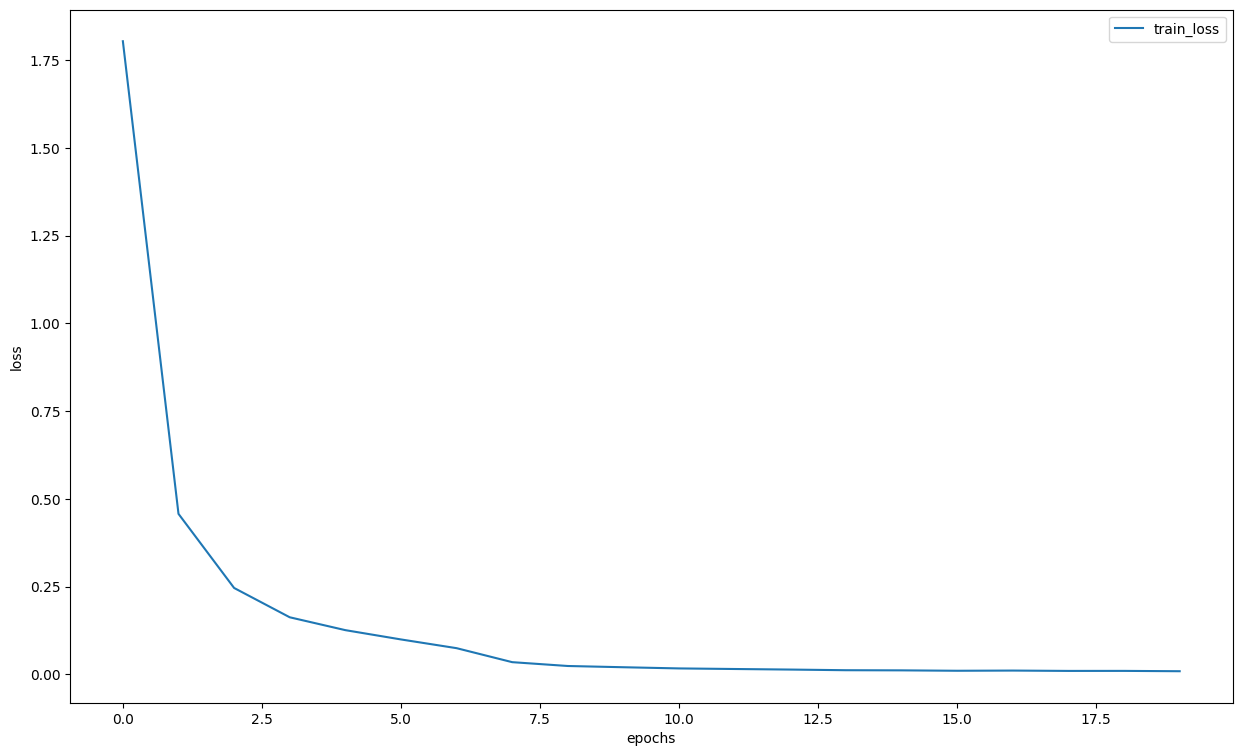

In [21]:
plt.figure(figsize=(15, 9))
plt.plot(loss, label="train_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

In [22]:
probs = predict(model, test_loader)
preds = [train_dataset.classes[i] for i in probs.argmax(axis=-1)]
test_filenames = [path.name for path in test_dataset.files]

In [23]:
pd.DataFrame({
    "Id": test_filenames,
    "Expected": preds
}).to_csv('submission.csv', index=False)